## Prior instructions

Upload `_data.zip` to your runtime

## Installation 

In [ ]:
!pip install pretty_midi

## Folders creation

In [ ]:
!mkdir _data
!mkdir midi_results
!unzip "_data.zip" -d "_data"

## Imports

In [ ]:
import random
import os
import pretty_midi
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# torch stuff
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset

# we use GPU if available, otherwise CPU
device_to_use = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device_to_use)
print(f"Using {device_to_use} device")


Using cuda:0 device


## Fetching data function

In [ ]:
DATA_PATH = "_data"

def get_samples(style="J", train=True, n=100, random=False):
    """Return the preprocessed samples

    Parameters
    ----------
    style : str, optional
        Style of the music, one of {"J", "C"} (for "Jazz" and "Classic"), by default "J"
    train : bool, optional
        Whether to choose the train or validation set, by default True
    n : int, optional
        Number of samples which will be returned, by default 100
    random : bool, optional
        Whether to randomize the samples or not, by default False

    Returns
    -------
    List (of Numpy arrays)
        List of samples
    """
    if style == "J":
        folder = "JC_J"
        prefix = "jazz"
    elif style == "C":
        folder = "JC_C"
        prefix = "classic"
    else:
        raise Exception("'style' must be one of {'J', 'C'}")
    train_or_valid = "train" if train else "test"

    nb_samples = sum(
        1
        for item in os.listdir(f"{DATA_PATH}/{folder}/{train_or_valid}")
        if os.path.isfile(os.path.join(f"{DATA_PATH}/{folder}/{train_or_valid}", item))
    )
    numbers = list(range(1, nb_samples))
    if random:
        np.random.shuffle(numbers)
    numbers = numbers[:n]
    samples = []
    for i, number in enumerate(numbers):
        if os.path.isfile(f"{DATA_PATH}/{folder}/{train_or_valid}/{prefix}_piano_{train_or_valid}_{number}.npy"):
            sample = np.load(
                f"{DATA_PATH}/{folder}/{train_or_valid}/{prefix}_piano_{train_or_valid}_{number}.npy"
            )
            samples.append(sample.astype(int).reshape((1, 64 * 84)))

    return np.vstack(samples)

### Generator

In [ ]:
latent_dim = 512

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        n_features = latent_dim
        n_out = 64 * 84

        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 2048),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(2048, n_out),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        # x = self.hidden2(x)
        x = self.out(x)
        return x

### Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        n_features = 64 * 84
        n_out = 1

        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [ ]:
n = 1000
batch_size = 32
data = get_samples(style="J", n=n, random=True)
dataset = TensorDataset(torch.Tensor(data).type(torch.float), torch.Tensor(np.ones((data.shape[0], 1))).type(torch.int64))
loader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=batch_size)

### Training

Discriminator data distribution
Note played simultaneously (in avg) for real data : 5.77


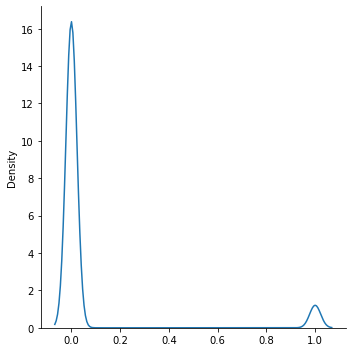

Epoch 0: D (0.7100 real_err, 0.5539 fake_err) G (0.8660 err) 
Time since beginning: 12.0 sec
Generated data: 
Min value: 0.3943113386631012 / Max value: 0.598637044429779
Note played simultaneously (in avg) for generated data : 41.99


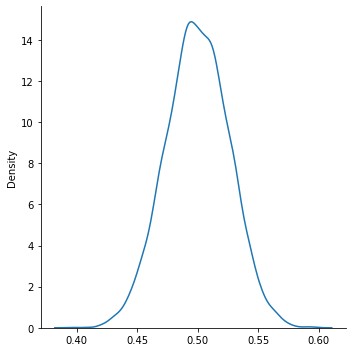

Epoch 10: D (0.4511 real_err, 0.0143 fake_err) G (3.5774 err) 
Time since beginning: 15.8 sec
Generated data: 
Min value: 0.40310439467430115 / Max value: 0.5907306671142578
Note played simultaneously (in avg) for generated data : 41.82


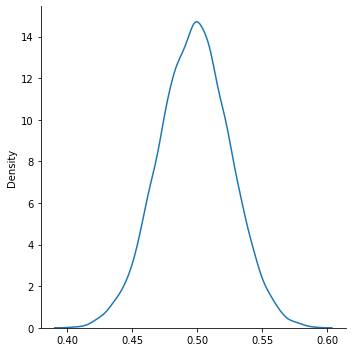

Epoch 20: D (0.1509 real_err, 0.0054 fake_err) G (5.1696 err) 
Time since beginning: 19.6 sec
Generated data: 
Min value: 0.36082884669303894 / Max value: 0.6096561551094055
Note played simultaneously (in avg) for generated data : 41.30


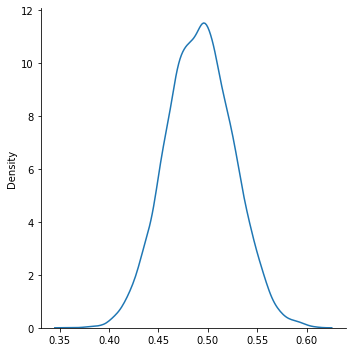

Epoch 30: D (0.0516 real_err, 0.0068 fake_err) G (3.3950 err) 
Time since beginning: 23.6 sec
Generated data: 
Min value: 0.059291888028383255 / Max value: 0.9558966755867004
Note played simultaneously (in avg) for generated data : 33.84


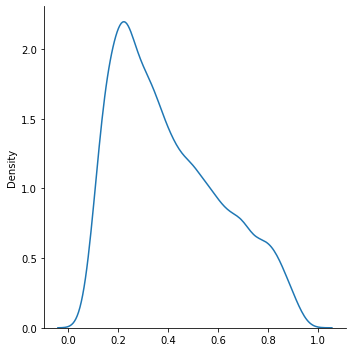

Epoch 40: D (0.0552 real_err, 0.0391 fake_err) G (3.9945 err) 
Time since beginning: 27.4 sec
Generated data: 
Min value: 0.0019485570956021547 / Max value: 0.9974697828292847
Note played simultaneously (in avg) for generated data : 15.73


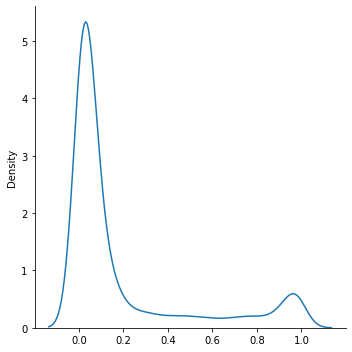

Epoch 50: D (0.0298 real_err, 0.0229 fake_err) G (4.3987 err) 
Time since beginning: 31.3 sec
Generated data: 
Min value: 0.0011403923854231834 / Max value: 0.9988327622413635
Note played simultaneously (in avg) for generated data : 10.57


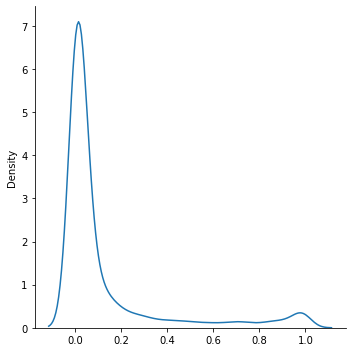

Epoch 60: D (0.0157 real_err, 0.0039 fake_err) G (4.1518 err) 
Time since beginning: 35.2 sec
Generated data: 
Min value: 0.00047430783160962164 / Max value: 0.999251663684845
Note played simultaneously (in avg) for generated data : 8.50


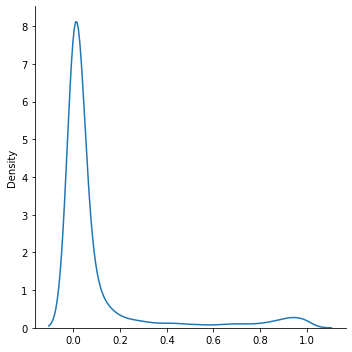

Epoch 70: D (0.0235 real_err, 0.1127 fake_err) G (3.5143 err) 
Time since beginning: 39.0 sec
Generated data: 
Min value: 0.00044938185601495206 / Max value: 0.9986685514450073
Note played simultaneously (in avg) for generated data : 5.51


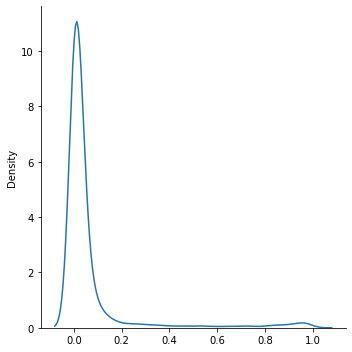

Epoch 80: D (0.0365 real_err, 0.1541 fake_err) G (2.6580 err) 
Time since beginning: 42.9 sec
Generated data: 
Min value: 1.927629637066275e-05 / Max value: 0.9971523284912109
Note played simultaneously (in avg) for generated data : 1.96


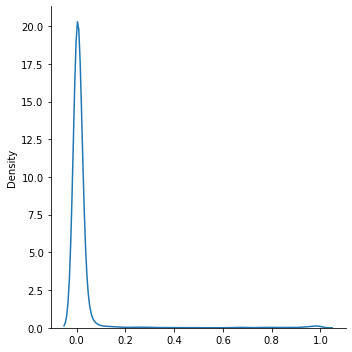

Epoch 90: D (0.0043 real_err, 0.0363 fake_err) G (3.6964 err) 
Time since beginning: 46.8 sec
Generated data: 
Min value: 2.053747812169604e-05 / Max value: 0.9989902377128601
Note played simultaneously (in avg) for generated data : 5.63


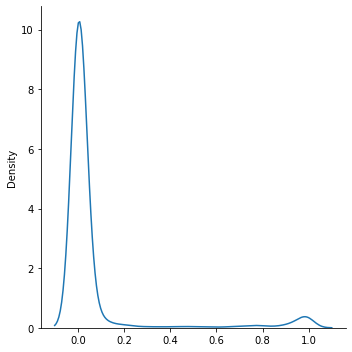

Epoch 100: D (0.1719 real_err, 0.0175 fake_err) G (4.9693 err) 
Time since beginning: 50.6 sec
Generated data: 
Min value: 4.675944728660397e-05 / Max value: 0.9990382194519043
Note played simultaneously (in avg) for generated data : 6.34


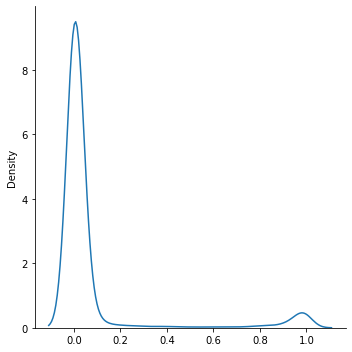

Epoch 110: D (0.0026 real_err, 0.0485 fake_err) G (3.7612 err) 
Time since beginning: 54.5 sec
Generated data: 
Min value: 9.873099043034017e-05 / Max value: 0.9991713762283325
Note played simultaneously (in avg) for generated data : 6.79


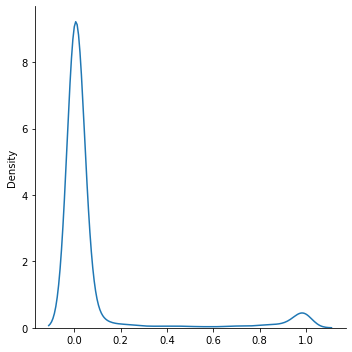

Epoch 120: D (0.0020 real_err, 0.0004 fake_err) G (6.0635 err) 
Time since beginning: 58.4 sec
Generated data: 
Min value: 0.00015305528359021991 / Max value: 0.998908281326294
Note played simultaneously (in avg) for generated data : 6.91


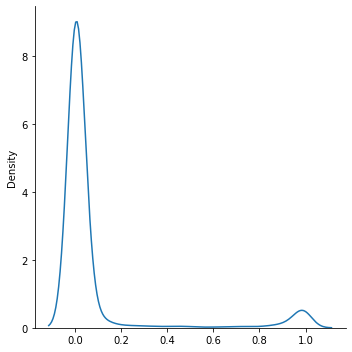

Epoch 130: D (0.0405 real_err, 0.0332 fake_err) G (9.2144 err) 
Time since beginning: 62.3 sec
Generated data: 
Min value: 0.00027906056493520737 / Max value: 0.9988102912902832
Note played simultaneously (in avg) for generated data : 8.15


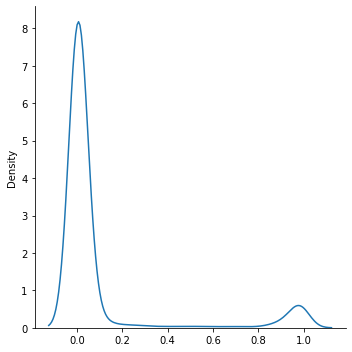

Epoch 140: D (0.0203 real_err, 0.0009 fake_err) G (9.9000 err) 
Time since beginning: 66.1 sec
Generated data: 
Min value: 0.001246356638148427 / Max value: 0.9969353675842285
Note played simultaneously (in avg) for generated data : 8.43


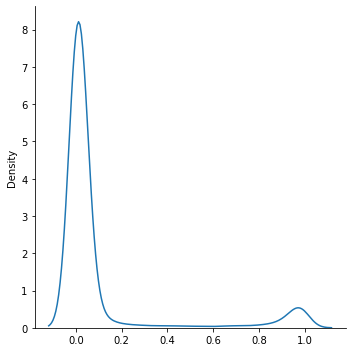

Epoch 150: D (0.0140 real_err, 0.4214 fake_err) G (9.2587 err) 
Time since beginning: 70.0 sec
Generated data: 
Min value: 0.0008591326768510044 / Max value: 0.9974024891853333
Note played simultaneously (in avg) for generated data : 7.60


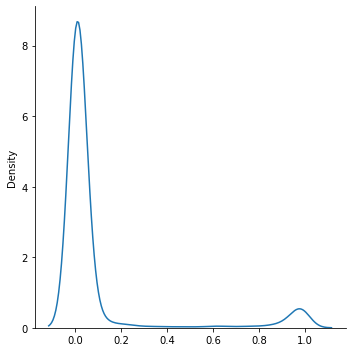

Epoch 160: D (0.0009 real_err, 0.0253 fake_err) G (6.7331 err) 
Time since beginning: 74.0 sec
Generated data: 
Min value: 0.0003421921283006668 / Max value: 0.9985156655311584
Note played simultaneously (in avg) for generated data : 6.55


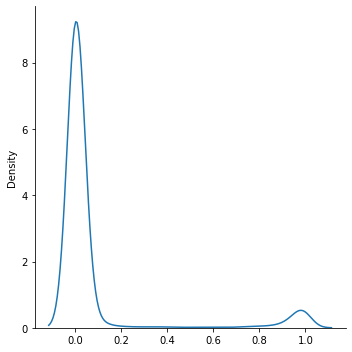

Epoch 170: D (0.0025 real_err, 0.0007 fake_err) G (5.3222 err) 
Time since beginning: 77.8 sec
Generated data: 
Min value: 0.00018616113811731339 / Max value: 0.9992808699607849
Note played simultaneously (in avg) for generated data : 6.04


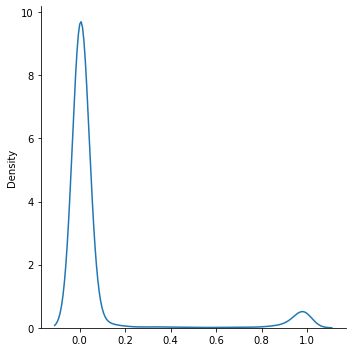

Epoch 180: D (0.0095 real_err, 0.0187 fake_err) G (6.5496 err) 
Time since beginning: 81.7 sec
Generated data: 
Min value: 0.00013284734450280666 / Max value: 0.9989292025566101
Note played simultaneously (in avg) for generated data : 5.38


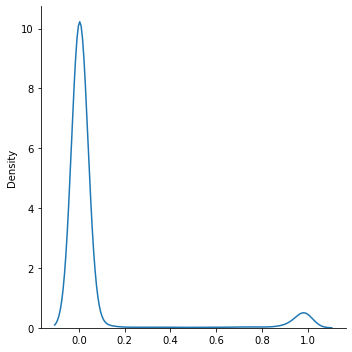

Epoch 190: D (0.0001 real_err, 0.0257 fake_err) G (5.9822 err) 
Time since beginning: 85.6 sec
Generated data: 
Min value: 0.00019785472250077873 / Max value: 0.9978062510490417
Note played simultaneously (in avg) for generated data : 4.22


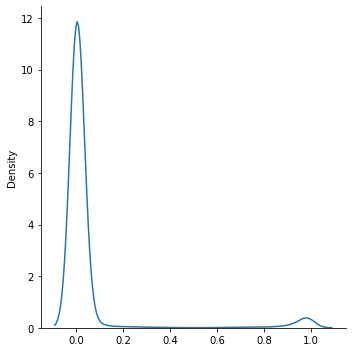

Epoch 200: D (0.0000 real_err, 0.0121 fake_err) G (6.9825 err) 
Time since beginning: 89.5 sec
Generated data: 
Min value: 0.00014375714818015695 / Max value: 0.9981375932693481
Note played simultaneously (in avg) for generated data : 3.63


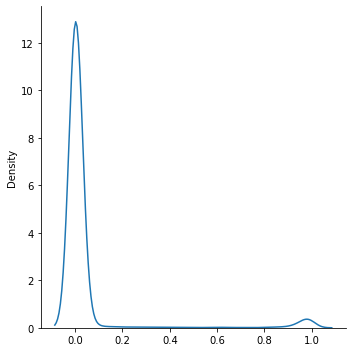

Epoch 210: D (0.0054 real_err, 0.0222 fake_err) G (4.8880 err) 
Time since beginning: 93.4 sec
Generated data: 
Min value: 0.0001951405283762142 / Max value: 0.9958622455596924
Note played simultaneously (in avg) for generated data : 2.83


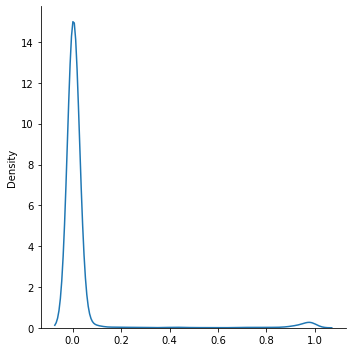

Epoch 220: D (0.0001 real_err, 0.0400 fake_err) G (4.1452 err) 
Time since beginning: 97.3 sec
Generated data: 
Min value: 6.994450086494908e-05 / Max value: 0.9974615573883057
Note played simultaneously (in avg) for generated data : 1.95


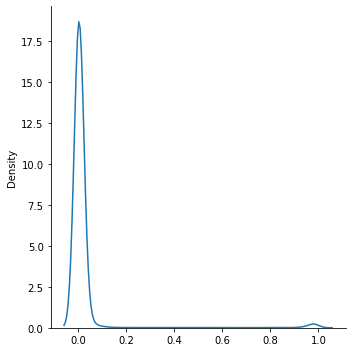

Epoch 230: D (0.0003 real_err, 0.0148 fake_err) G (4.7909 err) 
Time since beginning: 101.2 sec
Generated data: 
Min value: 0.0001365638745483011 / Max value: 0.9963812828063965
Note played simultaneously (in avg) for generated data : 2.31


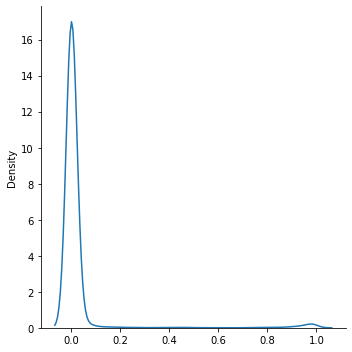

Epoch 240: D (0.0054 real_err, 0.0060 fake_err) G (4.6563 err) 
Time since beginning: 105.1 sec
Generated data: 
Min value: 0.00034869115916080773 / Max value: 0.9964229464530945
Note played simultaneously (in avg) for generated data : 3.51


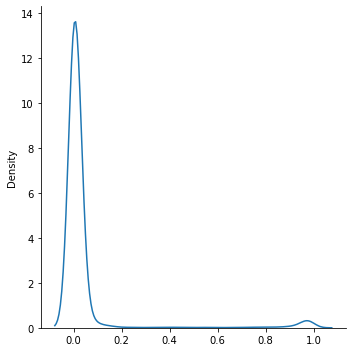

Epoch 250: D (0.0001 real_err, 0.0022 fake_err) G (8.4010 err) 
Time since beginning: 109.0 sec
Generated data: 
Min value: 0.00025610701413825154 / Max value: 0.9974473714828491
Note played simultaneously (in avg) for generated data : 5.64


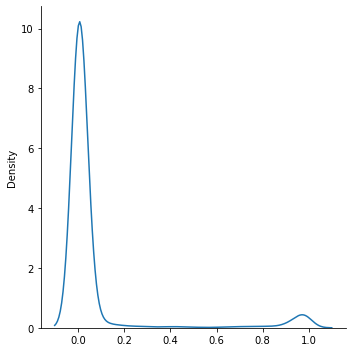

Epoch 260: D (0.0027 real_err, 0.0019 fake_err) G (6.8353 err) 
Time since beginning: 112.9 sec
Generated data: 
Min value: 0.00039054284570738673 / Max value: 0.9979959726333618
Note played simultaneously (in avg) for generated data : 6.81


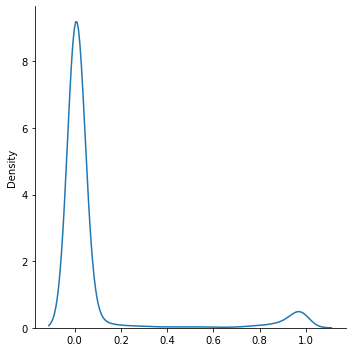

Epoch 270: D (0.0000 real_err, 0.0017 fake_err) G (7.0867 err) 
Time since beginning: 116.8 sec
Generated data: 
Min value: 0.0001595456269569695 / Max value: 0.9985418319702148
Note played simultaneously (in avg) for generated data : 6.38


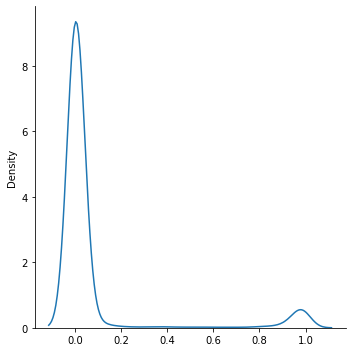

Epoch 280: D (0.0003 real_err, 0.0066 fake_err) G (5.7589 err) 
Time since beginning: 120.7 sec
Generated data: 
Min value: 0.0001608413876965642 / Max value: 0.9985774755477905
Note played simultaneously (in avg) for generated data : 6.09


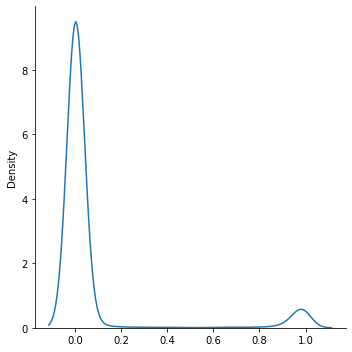

Epoch 290: D (0.0008 real_err, 0.0498 fake_err) G (7.4841 err) 
Time since beginning: 124.6 sec
Generated data: 
Min value: 0.00017591977666597813 / Max value: 0.9985083937644958
Note played simultaneously (in avg) for generated data : 5.52


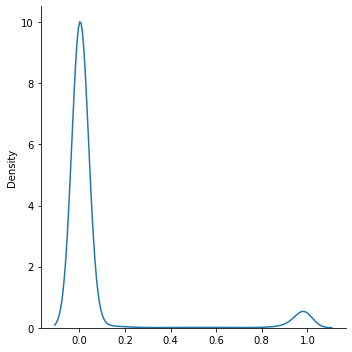

Epoch 300: D (0.0011 real_err, 0.0016 fake_err) G (8.2701 err) 
Time since beginning: 128.5 sec
Generated data: 
Min value: 5.5395663366653025e-05 / Max value: 0.9990468621253967
Note played simultaneously (in avg) for generated data : 4.79


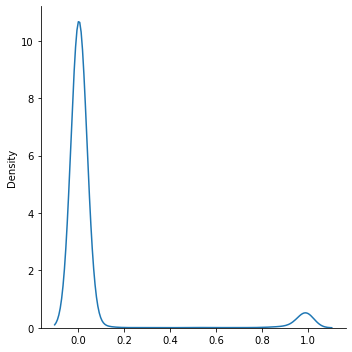

Epoch 310: D (0.0004 real_err, 0.0011 fake_err) G (6.4519 err) 
Time since beginning: 132.4 sec
Generated data: 
Min value: 7.019420445431024e-05 / Max value: 0.9990667700767517
Note played simultaneously (in avg) for generated data : 4.59


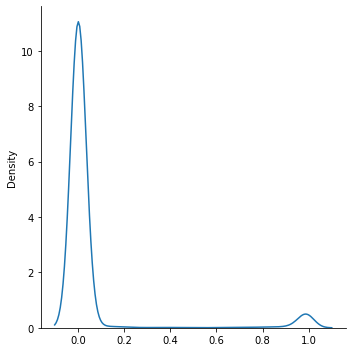

Epoch 320: D (0.0001 real_err, 0.0126 fake_err) G (6.4458 err) 
Time since beginning: 136.4 sec
Generated data: 
Min value: 8.68607748998329e-05 / Max value: 0.9987466335296631
Note played simultaneously (in avg) for generated data : 4.25


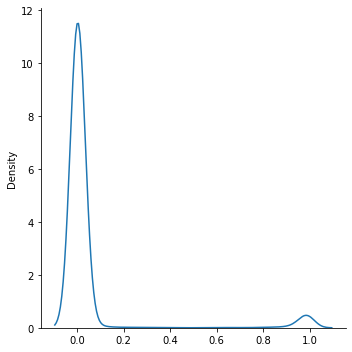

Epoch 330: D (0.0003 real_err, 0.0004 fake_err) G (5.4076 err) 
Time since beginning: 140.3 sec
Generated data: 
Min value: 7.866620580898598e-05 / Max value: 0.9984807372093201
Note played simultaneously (in avg) for generated data : 4.25


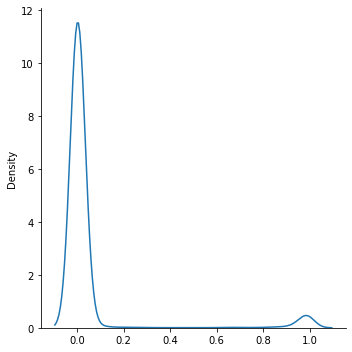

Epoch 340: D (0.0000 real_err, 0.0042 fake_err) G (6.3423 err) 
Time since beginning: 144.2 sec
Generated data: 
Min value: 9.185188537230715e-05 / Max value: 0.9985030889511108
Note played simultaneously (in avg) for generated data : 4.23


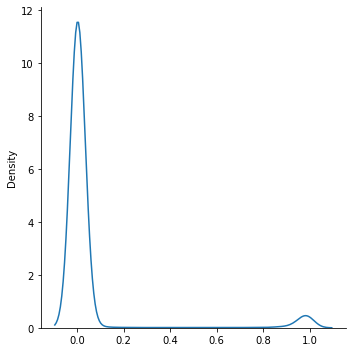

Epoch 350: D (0.0028 real_err, 0.0012 fake_err) G (4.4163 err) 
Time since beginning: 148.1 sec
Generated data: 
Min value: 2.5799019567784853e-05 / Max value: 0.999439537525177
Note played simultaneously (in avg) for generated data : 4.00


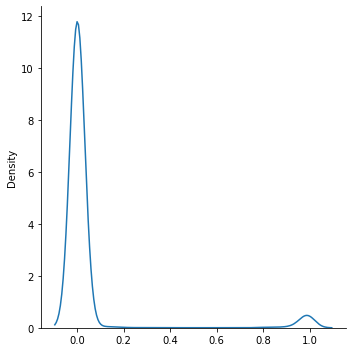

Epoch 360: D (0.0140 real_err, 0.0148 fake_err) G (6.4132 err) 
Time since beginning: 151.9 sec
Generated data: 
Min value: 0.00012171899288659915 / Max value: 0.9978134632110596
Note played simultaneously (in avg) for generated data : 4.14


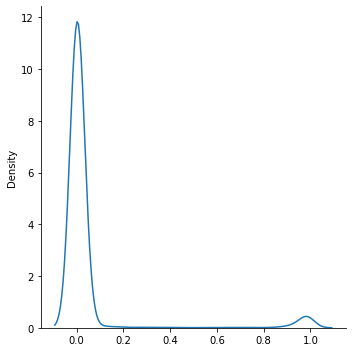

Epoch 370: D (0.0002 real_err, 0.0126 fake_err) G (6.3352 err) 
Time since beginning: 155.9 sec
Generated data: 
Min value: 0.00011818734492408112 / Max value: 0.9980192184448242
Note played simultaneously (in avg) for generated data : 4.15


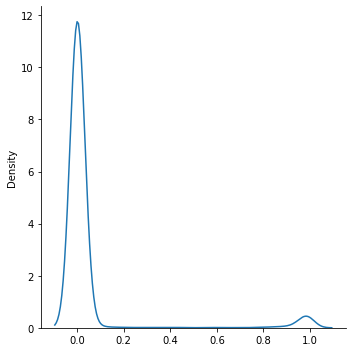

Epoch 380: D (0.0000 real_err, 0.0012 fake_err) G (6.7038 err) 
Time since beginning: 159.7 sec
Generated data: 
Min value: 8.319727203343064e-05 / Max value: 0.9986479878425598
Note played simultaneously (in avg) for generated data : 4.16


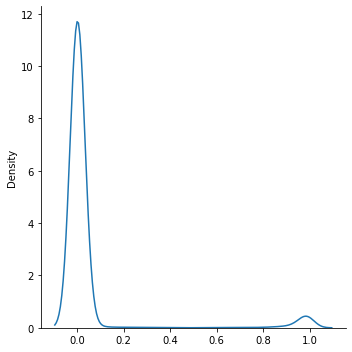

Epoch 390: D (0.0001 real_err, 0.0004 fake_err) G (7.0840 err) 
Time since beginning: 163.6 sec
Generated data: 
Min value: 0.00012287138088140637 / Max value: 0.9976338148117065
Note played simultaneously (in avg) for generated data : 4.37


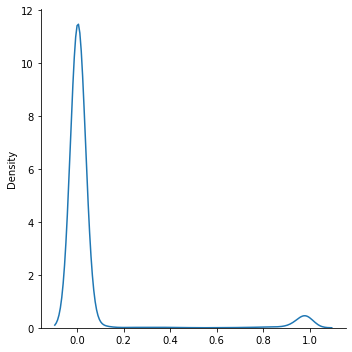

Epoch 400: D (0.0000 real_err, 0.0088 fake_err) G (6.8184 err) 
Time since beginning: 167.5 sec
Generated data: 
Min value: 9.203987428918481e-05 / Max value: 0.9980225563049316
Note played simultaneously (in avg) for generated data : 4.12


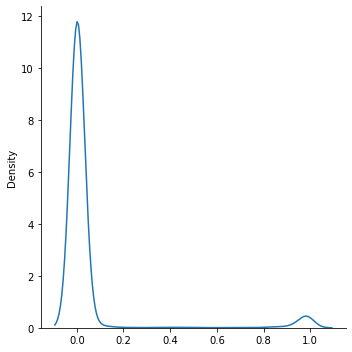

Epoch 410: D (0.1640 real_err, 0.0019 fake_err) G (7.5419 err) 
Time since beginning: 171.4 sec
Generated data: 
Min value: 0.0001667215838097036 / Max value: 0.9973830580711365
Note played simultaneously (in avg) for generated data : 4.08


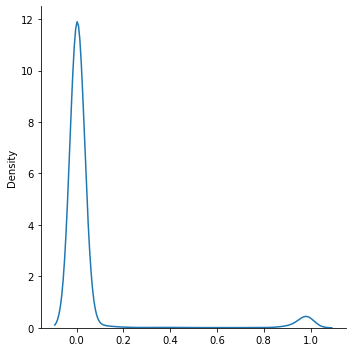

Epoch 420: D (0.0002 real_err, 0.0084 fake_err) G (7.5828 err) 
Time since beginning: 175.3 sec
Generated data: 
Min value: 6.005497925798409e-05 / Max value: 0.9991393089294434
Note played simultaneously (in avg) for generated data : 3.84


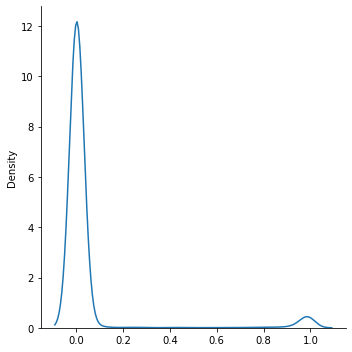

Epoch 430: D (0.0000 real_err, 0.0013 fake_err) G (5.7005 err) 
Time since beginning: 179.2 sec
Generated data: 
Min value: 0.00015944814367685467 / Max value: 0.9965386390686035
Note played simultaneously (in avg) for generated data : 3.88


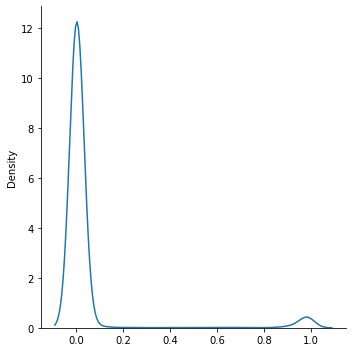

Epoch 440: D (0.0004 real_err, 0.0004 fake_err) G (6.4285 err) 
Time since beginning: 183.1 sec
Generated data: 
Min value: 0.00016039218462537974 / Max value: 0.997710108757019
Note played simultaneously (in avg) for generated data : 3.92


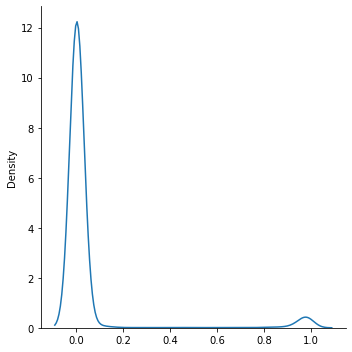

Epoch 450: D (0.0000 real_err, 0.0072 fake_err) G (6.3395 err) 
Time since beginning: 187.1 sec
Generated data: 
Min value: 7.285184256033972e-05 / Max value: 0.9985790252685547
Note played simultaneously (in avg) for generated data : 4.00


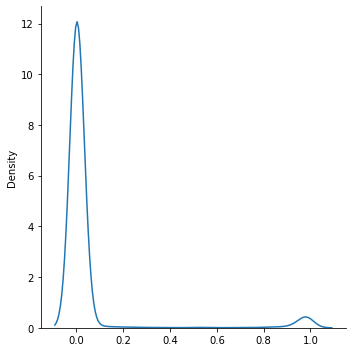

Epoch 460: D (0.0000 real_err, 0.0011 fake_err) G (7.3525 err) 
Time since beginning: 191.1 sec
Generated data: 
Min value: 0.00014245534839574248 / Max value: 0.9971612691879272
Note played simultaneously (in avg) for generated data : 3.82


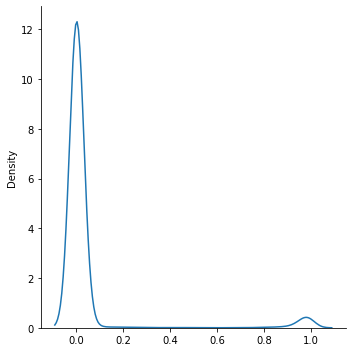

Epoch 470: D (0.0024 real_err, 0.0036 fake_err) G (7.1723 err) 
Time since beginning: 195.1 sec
Generated data: 
Min value: 6.412093352992088e-05 / Max value: 0.998630702495575
Note played simultaneously (in avg) for generated data : 3.60


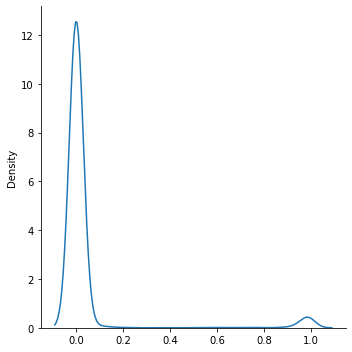

Epoch 480: D (0.0000 real_err, 0.0002 fake_err) G (7.1388 err) 
Time since beginning: 199.0 sec
Generated data: 
Min value: 7.878805627115071e-05 / Max value: 0.9982137680053711
Note played simultaneously (in avg) for generated data : 3.88


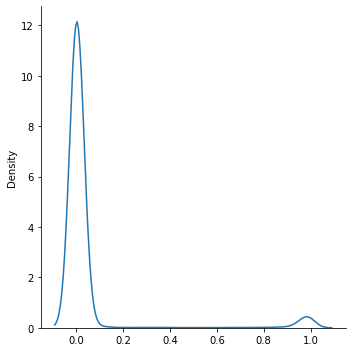

Epoch 490: D (0.1612 real_err, 0.0100 fake_err) G (5.8680 err) 
Time since beginning: 202.9 sec
Generated data: 
Min value: 0.0001411403063684702 / Max value: 0.9985260367393494
Note played simultaneously (in avg) for generated data : 4.22


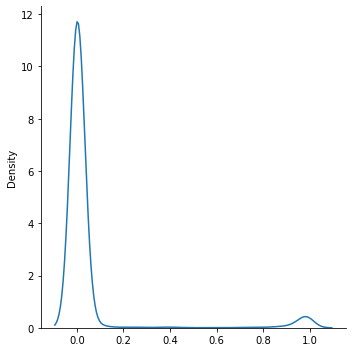

Epoch 500: D (0.0001 real_err, 0.0007 fake_err) G (7.1467 err) 
Time since beginning: 206.8 sec
Generated data: 
Min value: 0.0001359930174658075 / Max value: 0.998292863368988
Note played simultaneously (in avg) for generated data : 4.74


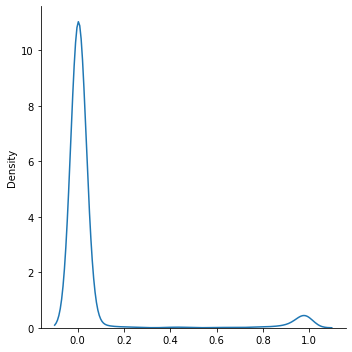

Epoch 510: D (0.0369 real_err, 0.0006 fake_err) G (8.5453 err) 
Time since beginning: 210.7 sec
Generated data: 
Min value: 0.0002372038143221289 / Max value: 0.9975185394287109
Note played simultaneously (in avg) for generated data : 5.02


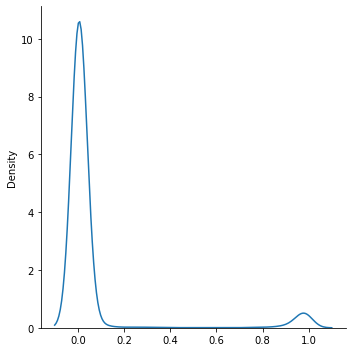

Epoch 520: D (0.0000 real_err, 0.0042 fake_err) G (5.9478 err) 
Time since beginning: 214.6 sec
Generated data: 
Min value: 0.00016094555030576885 / Max value: 0.9979817867279053
Note played simultaneously (in avg) for generated data : 5.73


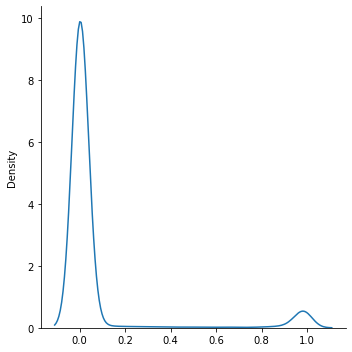

Epoch 530: D (0.0072 real_err, 0.0025 fake_err) G (8.4898 err) 
Time since beginning: 218.5 sec
Generated data: 
Min value: 0.00018380998517386615 / Max value: 0.9983540773391724
Note played simultaneously (in avg) for generated data : 6.66


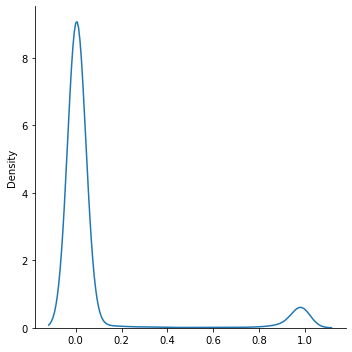

Epoch 540: D (0.0000 real_err, 0.0002 fake_err) G (6.6525 err) 
Time since beginning: 222.3 sec
Generated data: 
Min value: 0.00032813975121825933 / Max value: 0.998417854309082
Note played simultaneously (in avg) for generated data : 7.25


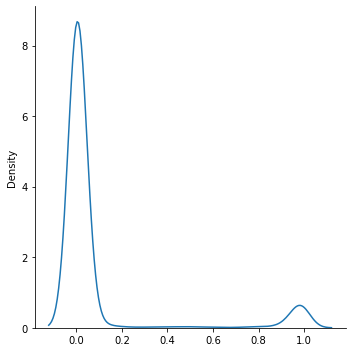

Epoch 550: D (0.0000 real_err, 0.0204 fake_err) G (12.3629 err) 
Time since beginning: 226.2 sec
Generated data: 
Min value: 0.0005190933006815612 / Max value: 0.9988020658493042
Note played simultaneously (in avg) for generated data : 10.54


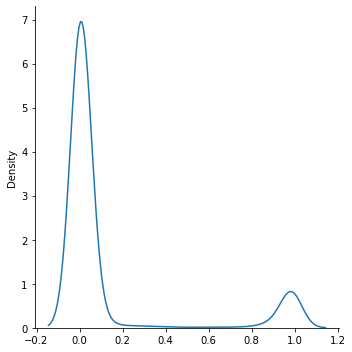

Epoch 560: D (0.0002 real_err, 0.0000 fake_err) G (20.4588 err) 
Time since beginning: 230.1 sec
Generated data: 
Min value: 0.000749038765206933 / Max value: 0.9992150068283081
Note played simultaneously (in avg) for generated data : 18.32


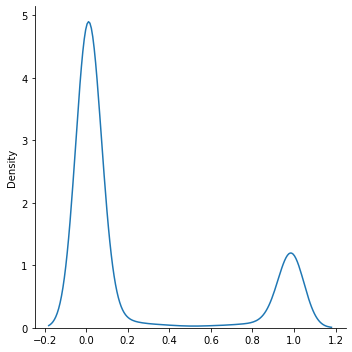

Epoch 570: D (0.0050 real_err, 0.0000 fake_err) G (9.9818 err) 
Time since beginning: 234.0 sec
Generated data: 
Min value: 0.00021156456205062568 / Max value: 0.9998376369476318
Note played simultaneously (in avg) for generated data : 23.15


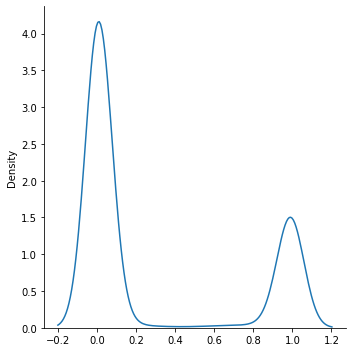

Epoch 580: D (0.0006 real_err, 0.0000 fake_err) G (14.7190 err) 
Time since beginning: 237.9 sec
Generated data: 
Min value: 5.6144202972063795e-05 / Max value: 0.9999359846115112
Note played simultaneously (in avg) for generated data : 22.91


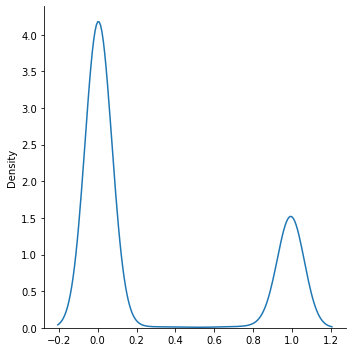

Epoch 590: D (0.0000 real_err, 0.0093 fake_err) G (18.3145 err) 
Time since beginning: 241.8 sec
Generated data: 
Min value: 3.928218939108774e-05 / Max value: 0.9999568462371826
Note played simultaneously (in avg) for generated data : 21.00


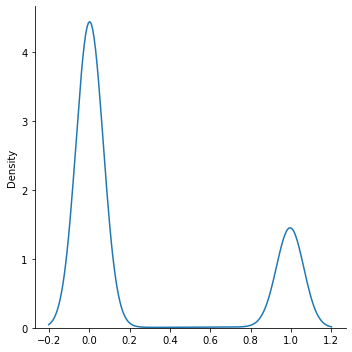

Epoch 600: D (0.0001 real_err, 0.0000 fake_err) G (10.4377 err) 
Time since beginning: 245.7 sec
Generated data: 
Min value: 1.461703323002439e-05 / Max value: 0.9999760389328003
Note played simultaneously (in avg) for generated data : 18.96


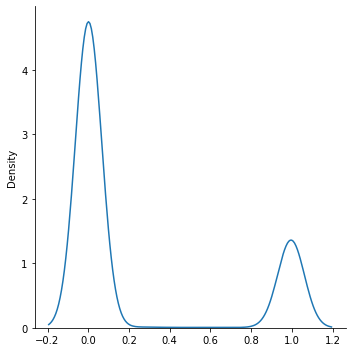

Epoch 610: D (0.0039 real_err, 0.0000 fake_err) G (16.1645 err) 
Time since beginning: 249.6 sec
Generated data: 
Min value: 1.4930148608982563e-05 / Max value: 0.999968409538269
Note played simultaneously (in avg) for generated data : 16.63


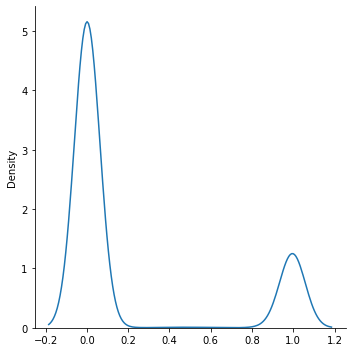

Epoch 620: D (0.0001 real_err, 0.0000 fake_err) G (16.0612 err) 
Time since beginning: 253.6 sec
Generated data: 
Min value: 8.979795893537812e-06 / Max value: 0.9999427795410156
Note played simultaneously (in avg) for generated data : 13.90


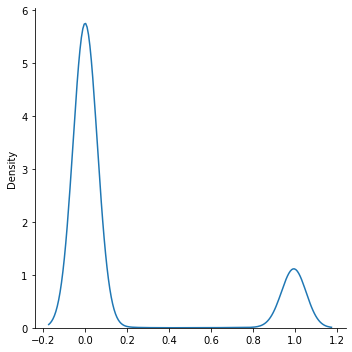

Epoch 630: D (0.0000 real_err, 0.0024 fake_err) G (11.8667 err) 
Time since beginning: 257.5 sec
Generated data: 
Min value: 1.8367642269367934e-06 / Max value: 0.9998165965080261
Note played simultaneously (in avg) for generated data : 8.91


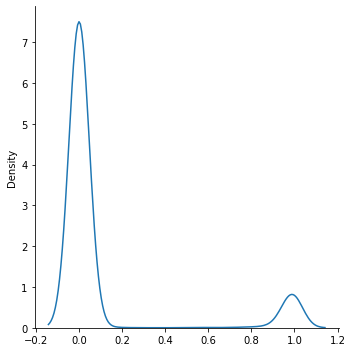

Epoch 640: D (0.0001 real_err, 0.0016 fake_err) G (8.6740 err) 
Time since beginning: 261.4 sec
Generated data: 
Min value: 1.5785968798809336e-07 / Max value: 0.9996391534805298
Note played simultaneously (in avg) for generated data : 3.59


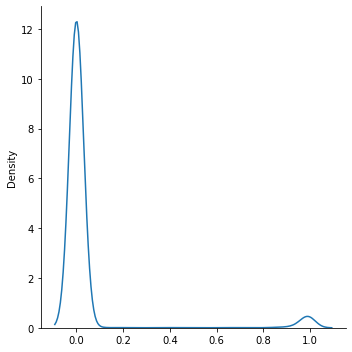

Epoch 650: D (0.0000 real_err, 0.0035 fake_err) G (5.1087 err) 
Time since beginning: 265.3 sec
Generated data: 
Min value: 3.810253801361796e-08 / Max value: 0.9991315007209778
Note played simultaneously (in avg) for generated data : 0.95


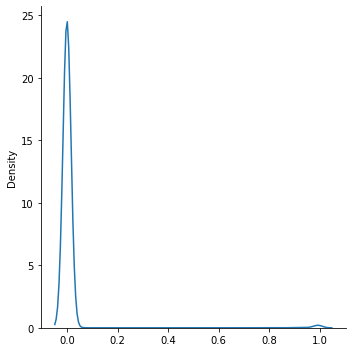

Epoch 660: D (0.0006 real_err, 0.1038 fake_err) G (2.6859 err) 
Time since beginning: 269.1 sec
Generated data: 
Min value: 2.9285862623851244e-08 / Max value: 0.9979124665260315
Note played simultaneously (in avg) for generated data : 0.07


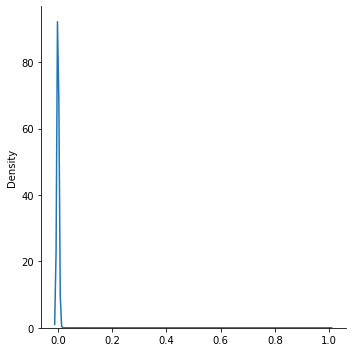

KeyboardInterrupt: ignored

In [ ]:
start_time = time.time()

n_epochs = 5000

G = Generator().to(device)
D = Discriminator().to(device)

loss = nn.BCELoss()

d_optimizer = optim.SGD(D.parameters(), lr=1e-3, momentum=0.8)
g_optimizer = optim.SGD(G.parameters(), lr=1e-3, momentum=0.8)

n_steps_discriminator = 1
n_steps_generator = 1


fake_data_list = []

def extract(v):
    return v.data.storage().tolist()
epochs = []
d_fake_errs = []
d_real_errs = []
g_errs = []
avg_notes = []

# d_avg_notes = 0

for epoch in range(n_epochs):
    for batch_idx, sample in enumerate(loader):

        D.zero_grad()  # could be d_optimizer.zero_grad() since the optimizer is specific to the model

        inputs, labels = sample
        N = len(inputs)
        # print(N)
        inputs_real_data, labels_real_data = inputs.to(device), labels.to(device)

        if epoch == 0 and batch_idx == 0:
            print("Discriminator data distribution")
            print(f"Note played simultaneously (in avg) for real data : {inputs_real_data.cpu().detach().numpy().flatten().sum() / ( N * 64):.2f}")
            sns.displot(inputs_real_data.cpu().detach().numpy().flatten(), kind="kde")
            plt.show()

        for _ in range(n_steps_discriminator):
            d_real_decision = D(inputs_real_data)
            d_real_error = loss(
                d_real_decision, Variable(torch.ones([N, 1])).to(device)
            )  # ones = true
            d_real_error.backward()  # compute/store gradients, but don't change params

            # train D on fake data
            d_gen_seed = Variable(torch.FloatTensor(torch.randn(N, latent_dim))).to(
                device
            )
            d_fake_data = G(d_gen_seed).detach()  # detach to avoid training G on these labels
            d_fake_decision = D(d_fake_data)
            d_fake_error = loss(
                d_fake_decision, Variable(torch.zeros([N, 1]).to(device))
            )  # zeros = fake
            d_fake_error.backward()
            d_optimizer.step()  # Only optimizes D's parameters; changes based on stored gradients from backward()

            dre, dfe = extract(d_real_error)[0], extract(d_fake_error)[0]

        for _ in range(n_steps_generator):
            G.zero_grad()
            g_gen_seed = Variable(torch.FloatTensor(torch.randn(N, latent_dim))).to(
                device
            )
            g_fake_data = G(g_gen_seed)
            dg_fake_decision = D(g_fake_data)
            g_error = loss(
                dg_fake_decision, Variable(torch.ones([N, 1]).to(device))
            )  # Train G to pretend it's genuine

            g_error.backward()
            g_optimizer.step()  # Only optimizes G's parameters

            ge = extract(g_error)[0]

    epochs.append(epoch)
    d_fake_errs.append(dfe)
    d_real_errs.append(dre)
    g_errs.append(ge)

    numpy_fake_data = g_fake_data.cpu().detach().numpy()
    fake_data_list.append((epoch, numpy_fake_data[0, :], numpy_fake_data[1, :], numpy_fake_data[-1, :]))
    avg_notes.append(numpy_fake_data.sum() / (N * 64))

    if epoch % 10 == 0:
        print(
            "Epoch %s: D (%1.4f real_err, %1.4f fake_err) G (%1.4f err) "
            % (epoch, dre, dfe, ge)
        )
        print(f"Time since beginning: {time.time() - start_time:.1f} sec")
        print("Generated data:", f"\nMin value: {numpy_fake_data.min()} / Max value: {numpy_fake_data.max()}")
        print(f"Note played simultaneously (in avg) for generated data : {numpy_fake_data.sum() / (N * 64):.2f}")
        sns.displot(numpy_fake_data.flatten(), kind="kde")
        plt.show()
        

print(
    "Epoch %s: D (%1.4f real_err, %1.4f fake_err) G (%1.4f err) "
    % (epoch, dre, dfe, ge)
)

## Loss evolution

Text(0, 0.5, 'error')

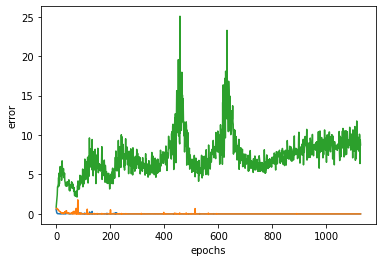

In [ ]:
plt.plot(epochs, d_fake_errs)
plt.plot(epochs, d_real_errs)
plt.plot(epochs, g_errs)
plt.xlabel("epochs")
plt.ylabel("error")

## Results export

In [ ]:
def raw_to_midi(array, name, precision=1e-2):
    pm = pretty_midi.PrettyMIDI()
    # Create an Instrument instance
    program = pretty_midi.instrument_name_to_program('Cello')
    piano = pretty_midi.Instrument(program=program)
    array = np.array(list(map(lambda x: 0 if x < precision else 1, array)))
    array = array.reshape((64, 84))
    for time_idx in range(64):
        for pitch_idx in range(84):
            if array[time_idx, pitch_idx] == 1:
                note = pretty_midi.Note(
                velocity=100, pitch=25 + pitch_idx, start=1 / 16 * time_idx, end=1 / 16 * (time_idx + 1))
                # Add it to our instrument
                piano.notes.append(note)
    pm.instruments.append(piano)
    # Write out the MIDI data
    pm.write(f'midi_results/{name}.mid')
    
        



In [ ]:
year, month, day = str(datetime.date.today()).split("-")
f_to_midi = [980, 600, 560, 500, 440, 460]  # Select the epochs you want an export for
indices = []
for idx in f_to_midi:
  indices.append([t[0] for t in fake_data_list].index(idx))

for i, idx in enumerate(indices):
  raw_to_midi(fake_data_list[idx][1], f"{month}_{day}_{f_to_midi[i]}", precision=0.5)
